In [1]:
#Importing libraries
# pip install nb_black
# pip install torchsummary
import torch
import torchvision
from torchvision import datasets,transforms,models
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import torch.optim as optim
from torchsummary import summary
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
#Dataset path
data_dir = r'E:\project\dataset'

<IPython.core.display.Javascript object>

In [3]:
#transforming using pytorch methods
transformer = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)
database = ImageFolder(data_dir, transform=transformer)

<IPython.core.display.Javascript object>

In [4]:
database

Dataset ImageFolder
    Number of datapoints: 390
    Root location: E:\project\dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

<IPython.core.display.Javascript object>

In [5]:
indices = list(range(len(database)))
training_size = int(np.floor(0.77*len(database)))
test_size = int(np.floor(0.12*len(database)))
validation_size = len(database)-training_size-test_size
np.random.shuffle(indices)
print(training_size, validation_size, test_size, len(database))

300 44 46 390


<IPython.core.display.Javascript object>

In [6]:
train_indices, validation_indices,test_indices = (
    indices[:training_size],
    indices[training_size:(training_size+validation_size)],
    indices[(training_size+validation_size):]
)
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)
targets_size = len(database.class_to_idx)

<IPython.core.display.Javascript object>

In [7]:
#Initializing batch size and creating list of batches in train and test datasets
batch_size = 16
train_loader = torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=validation_sampler)
test_loader=torch.utils.data.DataLoader(database, batch_size=batch_size,sampler=test_sampler)

<IPython.core.display.Javascript object>

In [8]:
classes = ('Aloe_Vera','Amla','Ashoka','Ashwagandha','Bael','Cinnamon','Henna','Lavender','Marigold','Neem','Peppermint','Tulsi','Turmeric')


<IPython.core.display.Javascript object>

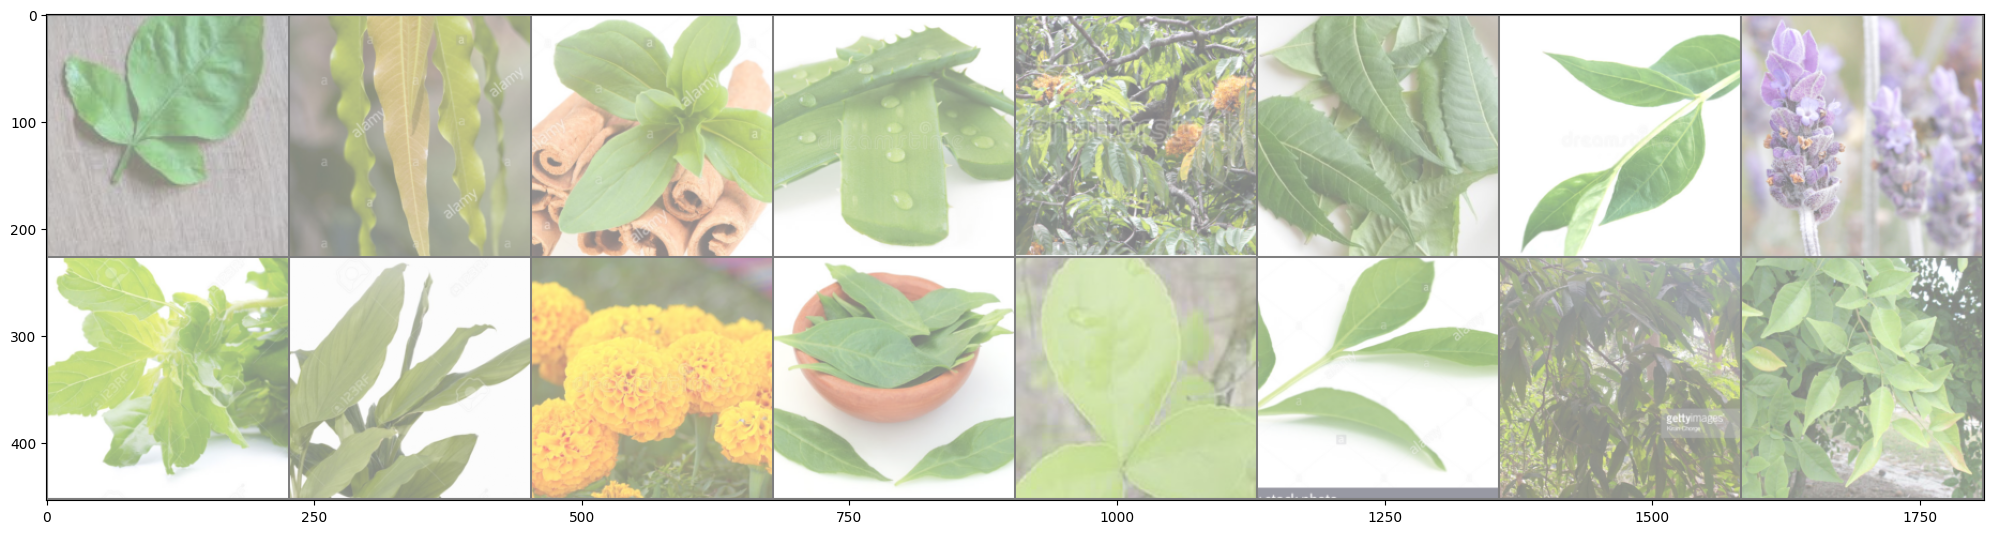

Bael  Ashoka Cinnamon Aloe_Vera Ashoka Neem  Henna Lavender Tulsi Turmeric Marigold Henna Bael  Henna Ashoka Bael 


<IPython.core.display.Javascript object>

In [9]:
#Showing random images from a single random batch in a grid format
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Original Modelling

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 13),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

model=CNN()

<IPython.core.display.Javascript object>

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

<IPython.core.display.Javascript object>

In [12]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

<IPython.core.display.Javascript object>

In [13]:
#creating optimizer
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

<IPython.core.display.Javascript object>

In [14]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    train_accs = np.zeros(epochs)
    validation_accs = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        train_acc = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / len(targets)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)

        validation_loss = []
        validation_acc = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / len(targets)
            validation_acc.append(acc)
            loss.backward()
            optimizer.step()

        validation_loss = np.mean(validation_loss)
        validation_acc = np.mean(validation_acc)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss
        train_accs[e] = train_acc
        validation_accs[e] = validation_acc

        dt = datetime.now() - t0

        print(f"Epoch:{e+1}/{epochs}\tTL:{train_loss:.3f}\tVL:{validation_loss:.3f}\tTA:{train_acc:.3f}\tVA:{validation_acc:.3f}\tDuration:{dt}")



    return train_losses, validation_losses, train_accs, validation_accs

<IPython.core.display.Javascript object>

In [15]:
train_losses, validation_losses, train_accs, validation_accs = batch_gd(model, criterion, train_loader, validation_loader, 10)


Epoch:1/10	TL:18.892	VL:21.517	TA:0.101	VA:0.201	Duration:0:00:46.064180
Epoch:2/10	TL:20.916	VL:20.699	TA:0.127	VA:0.132	Duration:0:00:46.317484
Epoch:3/10	TL:18.968	VL:13.593	TA:0.138	VA:0.208	Duration:0:00:45.861544
Epoch:4/10	TL:17.887	VL:11.181	TA:0.200	VA:0.229	Duration:0:00:46.266450
Epoch:5/10	TL:13.652	VL:8.815	TA:0.183	VA:0.236	Duration:0:00:46.369499
Epoch:6/10	TL:9.534	VL:6.614	TA:0.234	VA:0.368	Duration:0:00:46.211652
Epoch:7/10	TL:4.940	VL:3.998	TA:0.298	VA:0.479	Duration:0:00:46.073021
Epoch:8/10	TL:3.375	VL:1.818	TA:0.396	VA:0.514	Duration:0:00:46.205085
Epoch:9/10	TL:3.295	VL:1.022	TA:0.485	VA:0.743	Duration:0:00:45.973031
Epoch:10/10	TL:2.578	VL:1.556	TA:0.512	VA:0.681	Duration:0:00:46.048978


<IPython.core.display.Javascript object>

In [16]:
torch.save(model.state_dict(),"plant.pt")

<IPython.core.display.Javascript object>

Load Model

In [17]:
model=CNN()
model.load_state_dict(torch.load("plant.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

<IPython.core.display.Javascript object>

Plot the loss


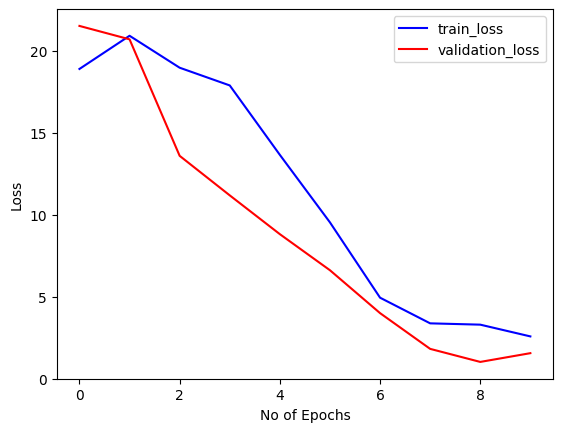

<IPython.core.display.Javascript object>

In [18]:
plt.plot(train_losses,'b' , label = 'train_loss')
plt.plot(validation_losses,'r',label='validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the accuracy graph

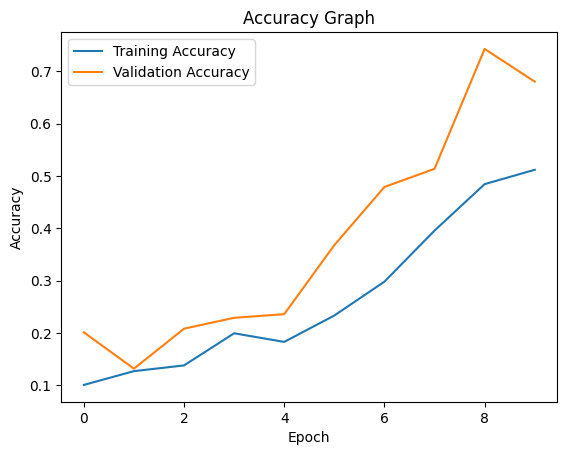

<IPython.core.display.Javascript object>

In [19]:
plt.plot(train_accs, label='Training Accuracy')
plt.plot(validation_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

In [20]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cpu()
    for inputs, targets in loader:
        inputs, targets = inputs.cpu(), targets.cpu()

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

<IPython.core.display.Javascript object>

In [21]:
train_acc = accuracy(train_loader)
validation_acc = accuracy(validation_loader)

<IPython.core.display.Javascript object>

In [22]:
print(
    f"Train Accuracy : {train_acc*100} %\nValidation Accuracy : {validation_acc*100} %"
)

Train Accuracy : 95.0 %
Validation Accuracy : 97.72727272727273 %


<IPython.core.display.Javascript object>

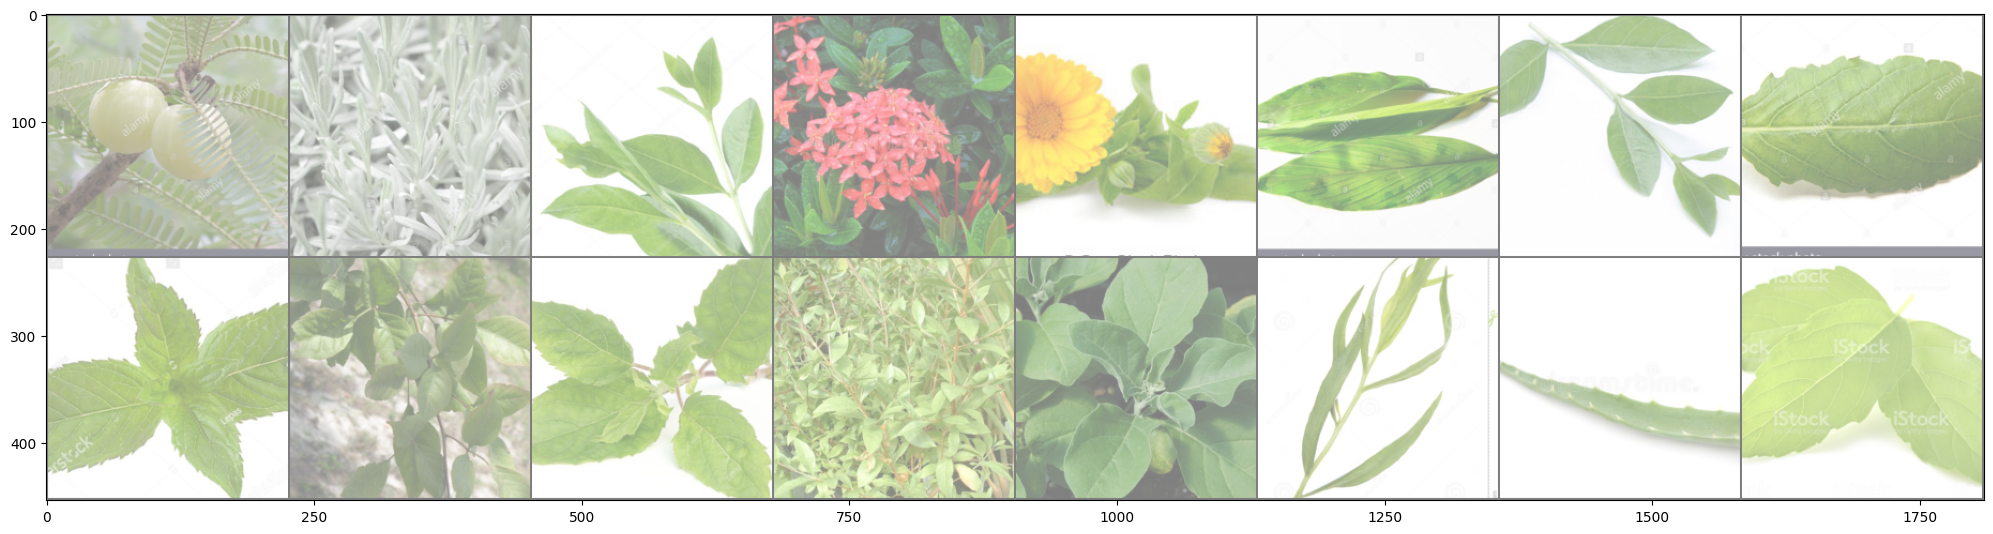

GroundTruth:  Amla  Lavender Henna Ashoka Marigold Turmeric Henna Tulsi Peppermint Bael  Henna Henna Ashwagandha Lavender Aloe_Vera Tulsi


<IPython.core.display.Javascript object>

In [23]:
# Showing sample images from a batch of test dataset
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [24]:
outputs = model(images)

<IPython.core.display.Javascript object>

In [25]:
# Sample predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Amla  Turmeric Henna Ashoka Marigold Turmeric Henna Tulsi Peppermint Bael  Henna Henna Ashwagandha Lavender Aloe_Vera Tulsi


<IPython.core.display.Javascript object>

In [26]:
#Series and dataframes to store actual and predicted values.
test_results = pd.DataFrame(columns = ['Actual_Image','Predicted_Image'])
Actual_Image= pd.Series(name='Actual_Image',dtype = str)
Predicted_Image= pd.Series(name='Predicted_Image',dtype = str)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        Actual_Image = pd.concat([Actual_Image, pd.Series(labels.tolist(), name='Actual_Image')], ignore_index=True)
        Predicted_Image = pd.concat([Predicted_Image, pd.Series(predicted.tolist(), name='Predicted_Image')], ignore_index=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy : {100 * correct / total} %')

Test accuracy : 95.65217391304348 %


<IPython.core.display.Javascript object>

In [27]:
# Creating the test results dataframe
test_results = pd.concat([Actual_Image, Predicted_Image], axis=1)

test_results['Actual_Image'] = test_results['Actual_Image'].map(
    {0: 'Aloe_Vera', 1: 'Amla', 2: 'Ashoka', 3: 'Ashwagandha', 4: 'Bael', 5: 'Cinnamon', 6: 'Henna', 7: 'Lavender', 8: 'Marigold', 9: 'Neem', 10: 'Peppermint', 11: 'Tulsi', 12: 'Turmeric'})
test_results['Predicted_Image'] = test_results['Predicted_Image'].map(
    {0: 'Aloe_Vera', 1: 'Amla', 2: 'Ashoka', 3: 'Ashwagandha', 4: 'Bael', 5: 'Cinnamon', 6: 'Henna', 7: 'Lavender', 8: 'Marigold', 9: 'Neem', 10: 'Peppermint', 11: 'Tulsi', 12: 'Turmeric'})
display(test_results)


Actual_Image Predicted_Image
0    Peppermint      Peppermint
1      Turmeric        Turmeric
2         Henna           Henna
3      Lavender        Turmeric
4      Marigold        Marigold
5         Henna           Henna
6          Neem            Neem
7         Henna           Henna
8          Bael            Bael
9         Henna           Henna
10     Lavender        Lavender
11         Neem            Neem
12     Lavender        Lavender
13     Turmeric        Turmeric
14   Peppermint      Peppermint
15       Ashoka          Ashoka
16   Peppermint      Peppermint
17         Amla            Amla
18         Neem            Neem
19         Amla            Amla
20       Ashoka          Ashoka
21         Bael            Bael
22        Henna           Henna
23        Tulsi           Tulsi
24     Lavender        Lavender
25     Marigold        Marigold
26     Turmeric        Turmeric
27        Tulsi           Tulsi
28     Turmeric        Turmeric
29     Marigold        Marigold
30     Turmeric        Turmeric
31        Tulsi           Tulsi
32     Turmeric        Turmeric
33        Henna           Henna
34   Peppermint      Peppermint
35       Ashoka          Ashoka
36        Henna           Henna
37     Turmeric        Turmeric
38       Ashoka          Ashoka
39  Ashwagandha     Ashwagandha
40    Aloe_Vera       Aloe_Vera
41  Ashwagandha     Ashwagandha
42        Henna           Henna
43        Henna           Henna
44       Ashoka            Bael
45        Tulsi           Tulsi

<IPython.core.display.Javascript object>

In [28]:
#Printing the metrics like confution matrix of final model prediction and also classification report.
print("Confusion matrix with true and predicted counts of each flower with ID:")
display(pd.crosstab(test_results['Actual_Image'].squeeze(), test_results['Predicted_Image'].squeeze(), rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix with true and predicted counts of each flower with ID:


Predicted    Aloe_Vera  Amla  Ashoka  Ashwagandha  Bael  Henna  Lavender  \
True                                                                       
Aloe_Vera            1     0       0            0     0      0         0   
Amla                 0     2       0            0     0      0         0   
Ashoka               0     0       4            0     1      0         0   
Ashwagandha          0     0       0            2     0      0         0   
Bael                 0     0       0            0     2      0         0   
Henna                0     0       0            0     0      9         0   
Lavender             0     0       0            0     0      0         3   
Marigold             0     0       0            0     0      0         0   
Neem                 0     0       0            0     0      0         0   
Peppermint           0     0       0            0     0      0         0   
Tulsi                0     0       0            0     0      0         0   
Turmeric             0     0       0            0     0      0         0   
All                  1     2       4            2     3      9         3   

Predicted    Marigold  Neem  Peppermint  Tulsi  Turmeric  All  
True                                                           
Aloe_Vera           0     0           0      0         0    1  
Amla                0     0           0      0         0    2  
Ashoka              0     0           0      0         0    5  
Ashwagandha         0     0           0      0         0    2  
Bael                0     0           0      0         0    2  
Henna               0     0           0      0         0    9  
Lavender            0     0           0      0         1    4  
Marigold            3     0           0      0         0    3  
Neem                0     3           0      0         0    3  
Peppermint          0     0           4      0         0    4  
Tulsi               0     0           0      4         0    4  
Turmeric            0     0           0      0         7    7  
All                 3     3           4      4         8   46

<IPython.core.display.Javascript object>

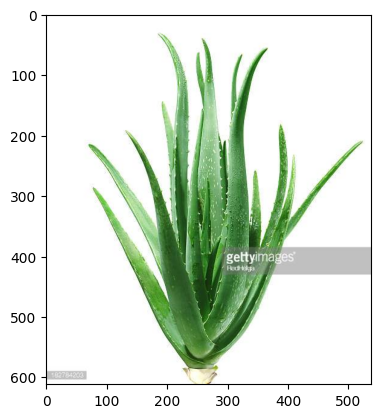

C:\Users\peris\AppData\Local\Temp\ipykernel_10424\464218673.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(outputs)


[[9.9761703e+01 2.5269815e-03 1.1434507e-02 8.4353858e-05 1.1269728e-03
  8.5124169e-03 8.2262231e-05 2.3022771e-02 2.5822697e-02 7.4311294e-02
  7.0495619e-03 2.1490918e-02 6.2835686e-02]]
Aloe_Vera       :    99.7617 %
Amla            :    0.0025 %
Ashoka          :    0.0114 %
Ashwagandha     :    0.0001 %
Bael            :    0.0011 %
Cinnamon        :    0.0085 %
Henna           :    0.0001 %
Lavender        :    0.023 %
Marigold        :    0.0258 %
Neem            :    0.0743 %
Peppermint      :    0.007 %
Tulsi           :    0.0215 %
Turmeric        :    0.0628 %


 Final Predicted image :  ALOE_VERA


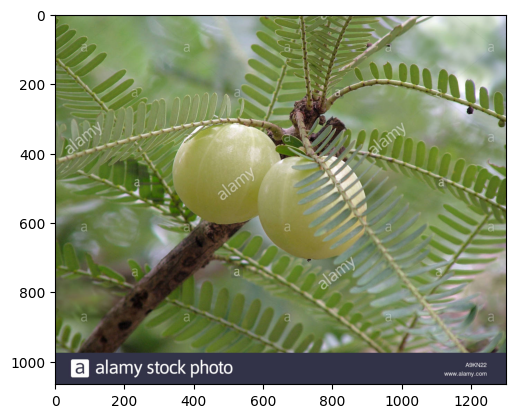

[[1.5242948e-04 9.9971146e+01 2.8135069e-04 3.2223377e-04 7.3133400e-03
  1.4786715e-02 1.4529666e-03 2.8729807e-03 1.2514013e-03 7.4482639e-05
  2.5770672e-07 1.8529128e-07 3.4083487e-04]]
Aloe_Vera       :    0.0002 %
Amla            :    99.9711 %
Ashoka          :    0.0003 %
Ashwagandha     :    0.0003 %
Bael            :    0.0073 %
Cinnamon        :    0.0148 %
Henna           :    0.0015 %
Lavender        :    0.0029 %
Marigold        :    0.0013 %
Neem            :    0.0001 %
Peppermint      :    0.0 %
Tulsi           :    0.0 %
Turmeric        :    0.0003 %


 Final Predicted image :  AMLA


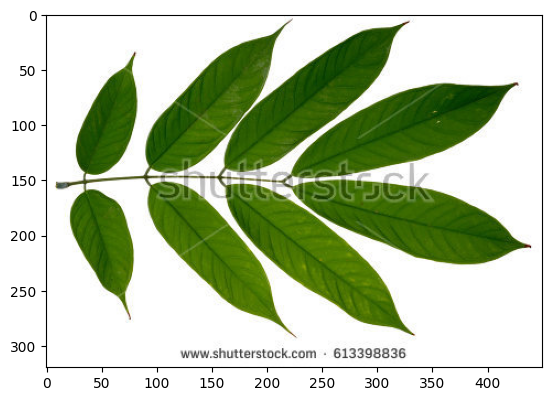

[[1.0910749e-03 1.4114892e-04 7.2232018e+01 5.5153208e-04 2.7765581e+01
  7.7533878e-06 9.9335966e-07 1.7858131e-06 5.9276852e-07 7.3887309e-06
  4.6821249e-05 4.9318319e-06 5.5596331e-04]]
Aloe_Vera       :    0.0011 %
Amla            :    0.0001 %
Ashoka          :    72.232 %
Ashwagandha     :    0.0006 %
Bael            :    27.7656 %
Cinnamon        :    0.0 %
Henna           :    0.0 %
Lavender        :    0.0 %
Marigold        :    0.0 %
Neem            :    0.0 %
Peppermint      :    0.0 %
Tulsi           :    0.0 %
Turmeric        :    0.0006 %


 Final Predicted image :  ASHOKA


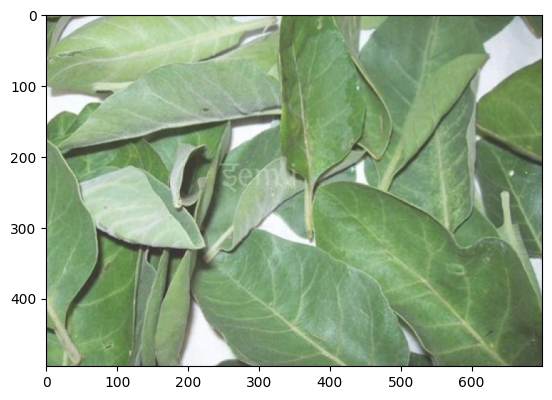

[[8.3388202e-03 1.3565692e-03 5.3038623e-04 9.9897179e+01 1.6309841e-02
  1.9108048e-03 6.9351008e-05 7.4131298e-03 4.7143530e-02 6.8945478e-04
  9.1477697e-05 4.8390129e-06 1.8974153e-02]]
Aloe_Vera       :    0.0083 %
Amla            :    0.0014 %
Ashoka          :    0.0005 %
Ashwagandha     :    99.8972 %
Bael            :    0.0163 %
Cinnamon        :    0.0019 %
Henna           :    0.0001 %
Lavender        :    0.0074 %
Marigold        :    0.0471 %
Neem            :    0.0007 %
Peppermint      :    0.0001 %
Tulsi           :    0.0 %
Turmeric        :    0.019 %


 Final Predicted image :  ASHWAGANDHA


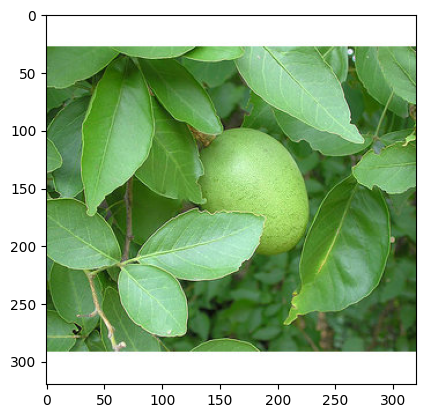

[[7.8894100e-11 1.9863580e-06 4.1968781e-12 2.2648723e-07 9.9999908e+01
  7.3137371e-06 1.7583142e-08 7.5291116e-09 2.4648292e-11 2.0193538e-08
  3.0037445e-14 1.7333426e-13 8.4237501e-05]]
Aloe_Vera       :    0.0 %
Amla            :    0.0 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    99.9999 %
Cinnamon        :    0.0 %
Henna           :    0.0 %
Lavender        :    0.0 %
Marigold        :    0.0 %
Neem            :    0.0 %
Peppermint      :    0.0 %
Tulsi           :    0.0 %
Turmeric        :    0.0001 %


 Final Predicted image :  BAEL


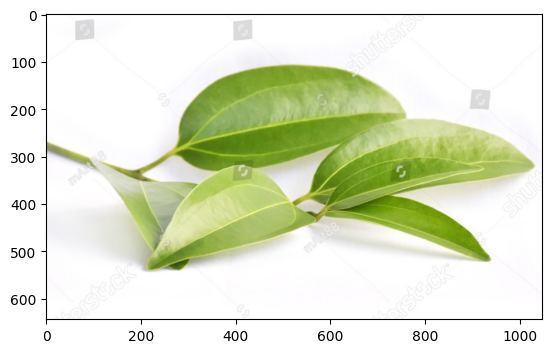

[[2.2937447e-02 5.5377260e-02 2.5851107e-03 4.2605343e-01 1.4318560e+00
  8.6867996e+01 1.8832902e+00 5.0934935e-01 2.0294841e-02 9.5478512e-02
  3.5917985e+00 2.4839842e-01 4.8445950e+00]]
Aloe_Vera       :    0.0229 %
Amla            :    0.0554 %
Ashoka          :    0.0026 %
Ashwagandha     :    0.4261 %
Bael            :    1.4319 %
Cinnamon        :    86.868 %
Henna           :    1.8833 %
Lavender        :    0.5093 %
Marigold        :    0.0203 %
Neem            :    0.0955 %
Peppermint      :    3.5918 %
Tulsi           :    0.2484 %
Turmeric        :    4.8446 %


 Final Predicted image :  CINNAMON


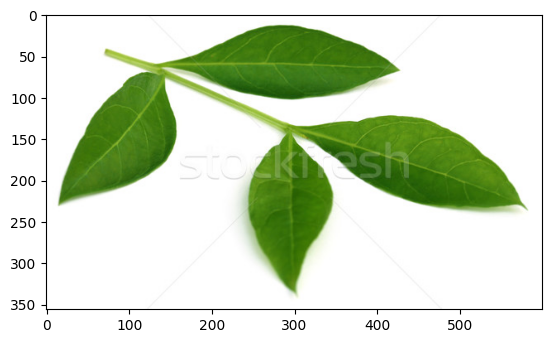

[[1.2747103e-07 1.7916103e-09 2.0856727e-05 2.5057543e-07 1.5928503e-05
  1.6747508e-03 9.9998283e+01 1.3609429e-06 6.7568061e-07 5.7398793e-06
  6.2152776e-07 4.4015621e-07 2.2959254e-07]]
Aloe_Vera       :    0.0 %
Amla            :    0.0 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    0.0 %
Cinnamon        :    0.0017 %
Henna           :    99.9983 %
Lavender        :    0.0 %
Marigold        :    0.0 %
Neem            :    0.0 %
Peppermint      :    0.0 %
Tulsi           :    0.0 %
Turmeric        :    0.0 %


 Final Predicted image :  HENNA


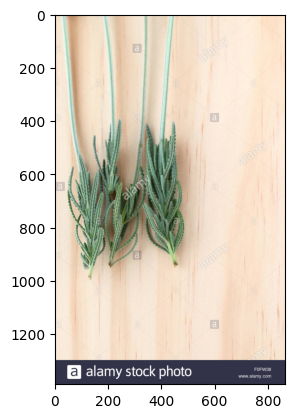

[[1.7827705e+01 3.1175635e+00 8.8145442e-02 4.9916368e-02 6.2801945e-01
  8.6423206e-01 4.7890268e-02 1.3499575e+01 2.9354746e+00 1.9654804e+00
  2.3615381e-02 1.6120286e-01 5.8791183e+01]]
Aloe_Vera       :    17.8277 %
Amla            :    3.1176 %
Ashoka          :    0.0881 %
Ashwagandha     :    0.0499 %
Bael            :    0.628 %
Cinnamon        :    0.8642 %
Henna           :    0.0479 %
Lavender        :    13.4996 %
Marigold        :    2.9355 %
Neem            :    1.9655 %
Peppermint      :    0.0236 %
Tulsi           :    0.1612 %
Turmeric        :    58.7912 %


 Final Predicted image :  TURMERIC


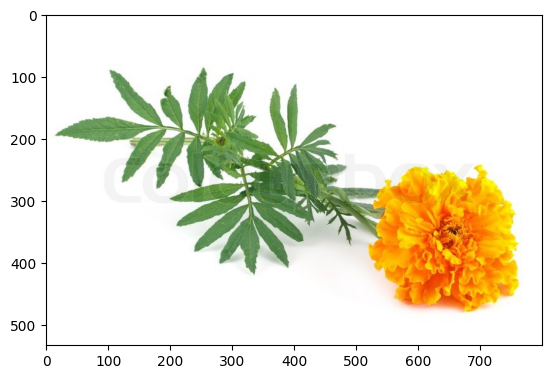

[[1.69123115e-18 6.36084368e-16 5.68525997e-28 1.01040555e-23
  6.83425341e-36 1.01489684e-18 3.15400074e-25 6.66873495e-21
  1.00000000e+02 1.60497240e-20 2.15472982e-29 7.90106079e-29
  9.34869088e-22]]
Aloe_Vera       :    0.0 %
Amla            :    0.0 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    0.0 %
Cinnamon        :    0.0 %
Henna           :    0.0 %
Lavender        :    0.0 %
Marigold        :    100.0 %
Neem            :    0.0 %
Peppermint      :    0.0 %
Tulsi           :    0.0 %
Turmeric        :    0.0 %


 Final Predicted image :  MARIGOLD


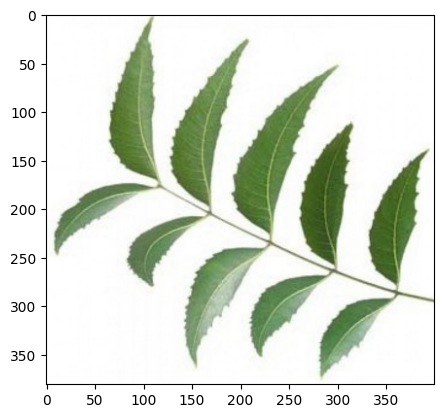

[[3.4803892e-03 3.5619184e-03 2.1843682e-05 8.9184960e-06 4.0659574e-03
  3.3583441e-03 1.3352856e-04 2.9826903e-04 3.8283638e-04 9.9890770e+01
  1.6171447e-04 5.0373940e-04 9.3272179e-02]]
Aloe_Vera       :    0.0035 %
Amla            :    0.0036 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    0.0041 %
Cinnamon        :    0.0034 %
Henna           :    0.0001 %
Lavender        :    0.0003 %
Marigold        :    0.0004 %
Neem            :    99.8908 %
Peppermint      :    0.0002 %
Tulsi           :    0.0005 %
Turmeric        :    0.0933 %


 Final Predicted image :  NEEM


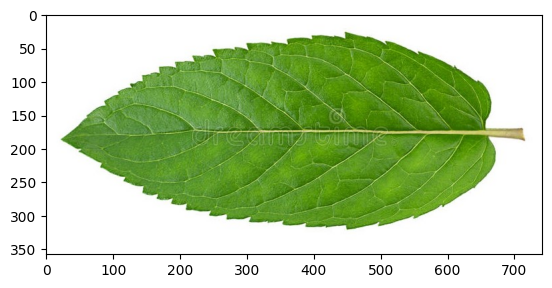

[[1.3121673e-04 6.6519193e-02 5.4050167e-04 1.7044124e-06 6.7631146e-03
  2.1877310e-01 1.7371237e+01 1.5313090e-02 2.0046589e-04 9.1959536e-04
  8.2178284e+01 6.4850667e-08 1.4132011e-01]]
Aloe_Vera       :    0.0001 %
Amla            :    0.0665 %
Ashoka          :    0.0005 %
Ashwagandha     :    0.0 %
Bael            :    0.0068 %
Cinnamon        :    0.2188 %
Henna           :    17.3712 %
Lavender        :    0.0153 %
Marigold        :    0.0002 %
Neem            :    0.0009 %
Peppermint      :    82.1783 %
Tulsi           :    0.0 %
Turmeric        :    0.1413 %


 Final Predicted image :  PEPPERMINT


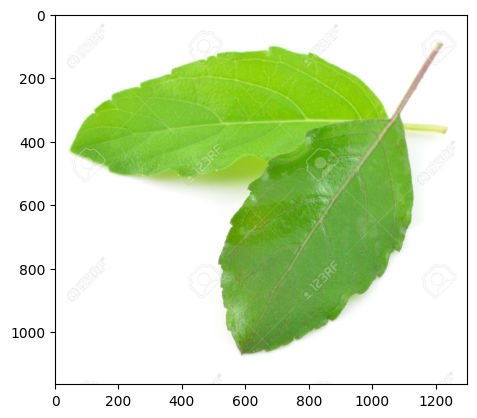

[[8.0017531e-10 2.6361577e-10 2.6817473e-08 2.8616425e-06 9.3348422e-09
  1.4079409e-02 2.9754969e-03 8.6809696e-06 2.5937456e-05 4.9748783e-06
  2.1036122e-07 9.9982895e+01 6.9192600e-07]]
Aloe_Vera       :    0.0 %
Amla            :    0.0 %
Ashoka          :    0.0 %
Ashwagandha     :    0.0 %
Bael            :    0.0 %
Cinnamon        :    0.0141 %
Henna           :    0.003 %
Lavender        :    0.0 %
Marigold        :    0.0 %
Neem            :    0.0 %
Peppermint      :    0.0 %
Tulsi           :    99.9829 %
Turmeric        :    0.0 %


 Final Predicted image :  TULSI


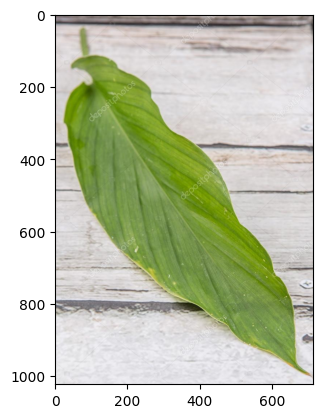

[[2.9071597e-03 7.4550370e-03 2.2909452e-01 7.8144930e-02 4.1737352e-02
  3.6365397e-03 8.3572365e-02 2.2161469e-02 2.5420221e-02 6.9370661e-03
  1.6772947e-03 9.1491239e-03 9.9488091e+01]]
Aloe_Vera       :    0.0029 %
Amla            :    0.0075 %
Ashoka          :    0.2291 %
Ashwagandha     :    0.0781 %
Bael            :    0.0417 %
Cinnamon        :    0.0036 %
Henna           :    0.0836 %
Lavender        :    0.0222 %
Marigold        :    0.0254 %
Neem            :    0.0069 %
Peppermint      :    0.0017 %
Tulsi           :    0.0091 %
Turmeric        :    99.4881 %


 Final Predicted image :  TURMERIC


<IPython.core.display.Javascript object>

In [29]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tkinter import *

win = tk.Tk()
win.attributes("-fullscreen",True)
win['background'] = '#58F'

font = ('georgia', 22, 'bold')
title = Label(win, text='Natural Image Detector                                                                                                               ')
title.config(bg='medium spring green', fg='dark goldenrod')
title.config(font=font)
title.config(height=3, width=120)
title.place(x=5, y=5)

font1 = ('times', 12, 'bold')
text = Text(win, height=20, width=80)

myscrollbar=Scrollbar(text)
text.configure(yscrollcommand=myscrollbar.set)
text.place(x=50, y=120)
text.config(font=font1)

font = ('black', 10, 'bold')
Imagetext = Label(win, text='IMAGE DISPLAY')
Imagetext.config(bg='white', fg='dark goldenrod')
Imagetext.config(font=font)
Imagetext.config(height=3, width=20)
Imagetext.place(x=1000, y=530)

font = ('black', 10, 'bold')
Imagetext2 = Label(win, text='**** PREDICTION ****')
Imagetext2.config(bg='white', fg='dark goldenrod')
Imagetext2.config(font=font)
Imagetext2.config(height=3, width=20)
Imagetext2.place(x=1320, y=120)

font1 = ('times',15, 'bold')
predict = Text(win, height=3, width=20)
predict.place(x=1320, y=200)
predict.config(font=font1)


frame = Frame(win, width=500, height=400, bg="lightblue", colormap="new")
frame.pack()
frame.place(x=800, y=120)

from PIL import Image
from torch.autograd import Variable
import matplotlib.image as mpimg

def get_probabilities(image):
  imgplot = plt.imshow(image)
  plt.show()
  image = transformer(image)
  image = image.float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
  outputs = model(image)
  _, predicted = torch.max(outputs.data, 1)
  sm = torch.nn.Softmax()
  probabilities = sm(outputs) 
  probabilities = probabilities.detach().numpy()
  print(probabilities*100) #Converted to probabilities
  text.delete('1.0', END)
  predict.delete('1.0',END)
  predict.insert(END, (classes[predicted.tolist()[0]]).upper())
  for i,j in enumerate(probabilities[0]):
    str_display = classes[i].ljust(15, ' ')  + ':   ' +  str(round(j*100,4)) + '%\n'
    text.insert(END, str_display)
    print(classes[i].ljust(15, ' ') ,':   ', round(j*100,4),'%')
  print('\n\n Final Predicted image : ', classes[predicted.tolist()[0]].upper())


def upload_file():
    global img
    for widget in frame.winfo_children():
        widget.destroy()
    f_types = [('Jpg Files', '*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    image2= img
    get_probabilities(img)
    img_resized=img.resize((500,400)) # new width & height
    img=ImageTk.PhotoImage(img_resized)
    label = Label(frame, image = img)
    label.pack()


def close():
   win.destroy()

b1 = tk.Button(win,text='Upload \nPhoto', width=20,command = lambda:upload_file())
b1.config(font=('times', 12, 'bold'))
b1.place(x=1000, y=600)

font = ('black', 10, 'bold')
probabilities = Label(win, text='Probabilities of each class')
probabilities.config(bg='white', fg='dark goldenrod')
probabilities.config(font=('times', 12, 'bold'))
probabilities.config(height=3, width=20)
probabilities.place(x=300, y=600)

exitButton = Button(win, text="Exit", command=close)
exitButton.place(x=1200, y=600)
exitButton.config(font=('times', 12, 'bold'))

win.mainloop()  # Keep the window open